# Duc Huy Nguyen - Statistics DRP Project Autumn 2025
## Relationship between Job Postings and Unemployment
### with related Economics metrics

We first import the required libraries for the project

In [455]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import CubicSpline

# Import some ML models from pygam and 
from pygam import LinearGAM, s, f, l
# By default, spline terms, s() have a penalty on their 2nd derivative, 
# which encourages the functions to be smoother, while factor terms, 
# f() and linear terms l(), have a l2, i.e. ridge penalty, which encourages them to take on smaller values.
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [456]:
# Suppress irrelevant warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading data and preliminary processing
We then load relevant datasets on job postings, unemployment, interest rates, inflation, stock prices and GDP into our notebook.

In [457]:
natural_unemp_df = pd.read_csv('Data/quarterly_natural_unemp.csv')
unemp_df = pd.read_csv('Data/monthly_unemployment_rate.csv') # Read Unemployment data
cpi_df = pd.read_csv('Data/monthly_cpi.csv') # Read CPI data
gdp_df = pd.read_csv('Data/quarterly_gdp.csv')# Read GDP data
job_df = pd.read_csv('Data/monthly_job_postings.csv')# Read Job Postings
sp500_df = pd.read_csv('Data/monthly_sp500.csv') # Read S&P 500 data
bond_df = pd.read_csv('Data/monthly_bonds.csv') # Read the bonds data
inflation_df = pd.read_csv('Data/monthly_inflation_rate.csv')
interest_df = pd.read_csv('Data/monthly_federal_funds_rate.csv') # Read the interest rates data

We format the time for our Dataframe 

In [458]:
for df in [natural_unemp_df, cpi_df, gdp_df, bond_df, unemp_df, interest_df, job_df, inflation_df]: # format dates for data got from FRED
    df.rename(columns={'observation_date' : 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

We then format the monthly stock price

In [459]:
for df in [sp500_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

In [460]:
# Resample the bonds returns
bond_df = bond_df.resample('MS').first()

### Estimating quarterly GDP from monthly GDP through interpolation

We then try to estimate the monthly GDP data using resampling and interpolation in Python.  
We are using linear spline to predict the months within 2025 Q3 without available data (this would be updated by FRED in Nov 26th 2025)

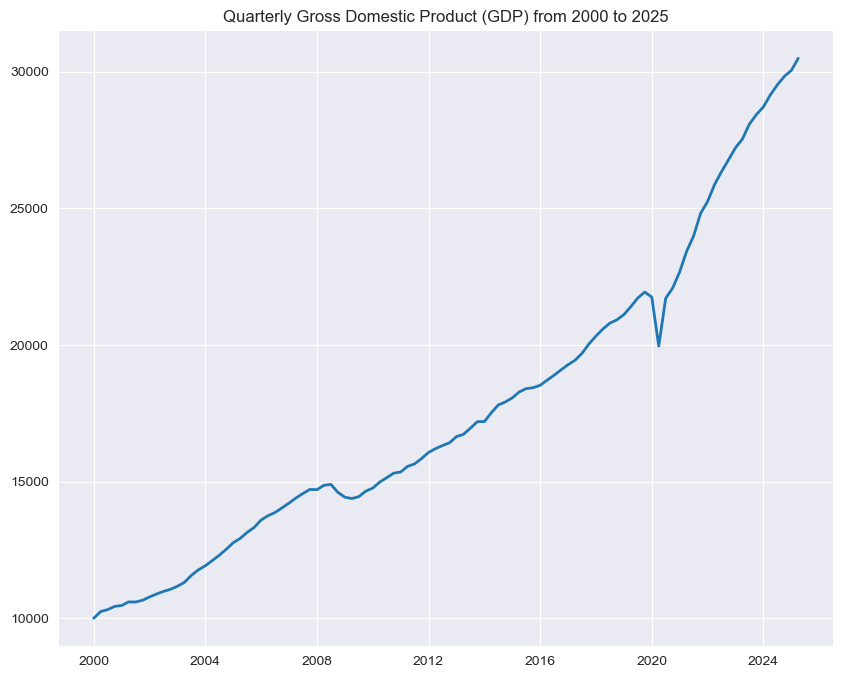

In [461]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Quarterly Gross Domestic Product (GDP) from 2000 to 2025')
plt.show()

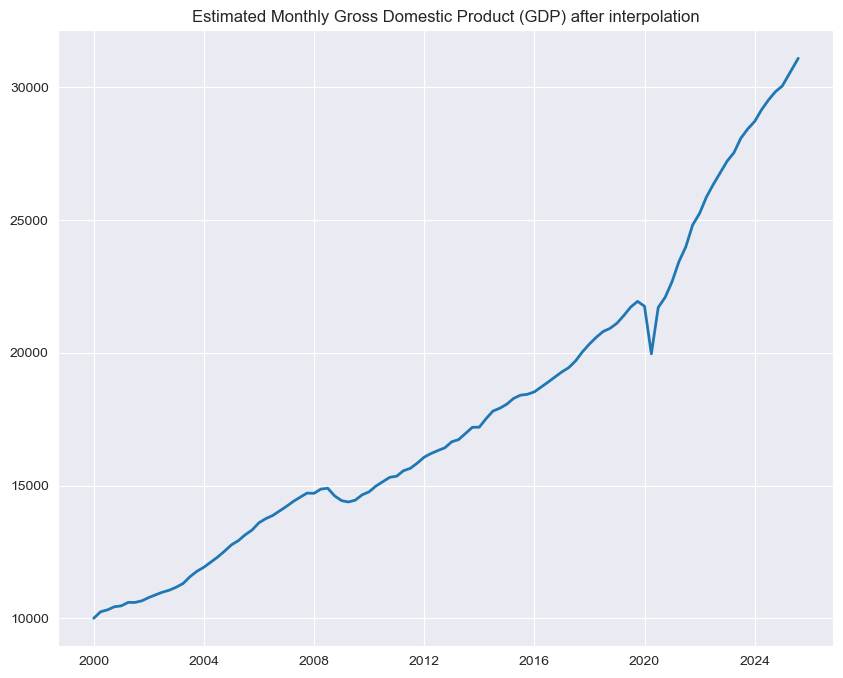

In [462]:
# We extend our current date time into the future
future_dates = pd.to_datetime(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])
extended_index = gdp_df.index.union(future_dates)

# print(extended_index)
gdp_df = gdp_df.reindex(extended_index)

# Then we interpolate the data 
gdp_df = gdp_df.resample('MS')
gdp_df = gdp_df.interpolate(method='spline', order = 1)

# Check the data after interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Estimated Monthly Gross Domestic Product (GDP) after interpolation')
plt.show()

### Estimating the monthly Natural Unemployment rate from quarterly rate


We then try to estimate the monthly natural rate of unemployment (NAIRU) data using resampling and interpolation in Python.  


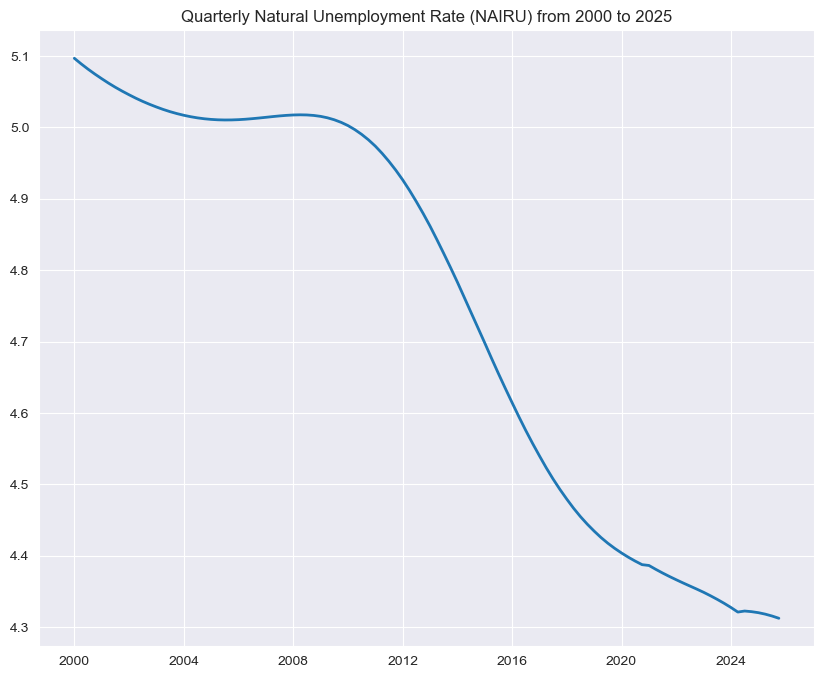

In [463]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], linewidth=2, markersize=12)
plt.title('Quarterly Natural Unemployment Rate (NAIRU) from 2000 to 2025')
plt.show()

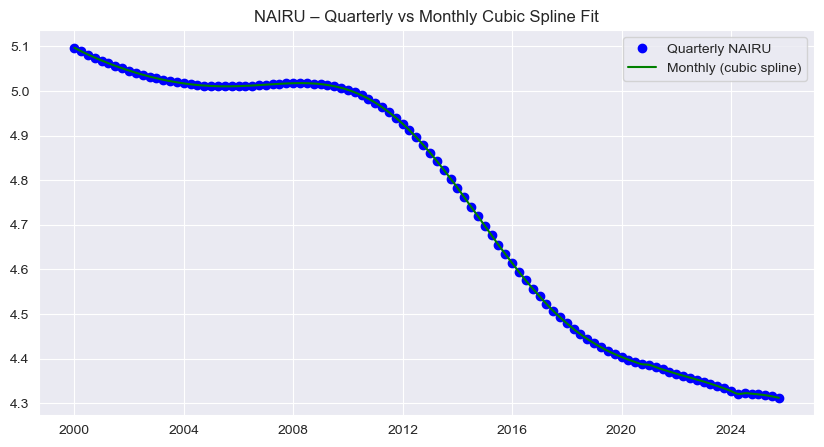

In [464]:
# With the pattern being represented, we use cubic spline interpolation to fit monthly data
# We interpolate the data 
# natural_unemp_df = natural_unemp_df.resample('MS')

# cubic spline with “natural” boundary conditions to reduce edge wiggles
cs = CubicSpline(natural_unemp_df.index.view('int64'), natural_unemp_df['NROU'], bc_type='natural')

# monthly dates from first to last quarter
monthly_natural_unemp_df = natural_unemp_df.resample('MS').first()
x_m = monthly_natural_unemp_df.index.view('int64')

nairu_monthly_cs = pd.DataFrame(cs(x_m), 
        index=monthly_natural_unemp_df.index, 
        columns=['NROU']
)

plt.figure(figsize=(10, 5))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], 'o', color='blue', label='Quarterly NAIRU')
plt.plot(nairu_monthly_cs.index, nairu_monthly_cs['NROU'], color='green', label='Monthly (cubic spline)')
plt.legend()
plt.title('NAIRU – Quarterly vs Monthly Cubic Spline Fit')
plt.show()

natural_unemp_df = nairu_monthly_cs.copy()

# Graph the data after interpolation
# fig, ax = plt.subplots(figsize=(10, 8))
# plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], linewidth=2, markersize=12)
# plt.title('Estimated Monthly Natural Rate of Unemployment (NAIRU) after interpolation')
# plt.show()

## Data Cleaning and Formatting 

In [465]:
print(cpi_df.head(5))
print(unemp_df.head(5))
print(job_df.head(5))
print(sp500_df.head(5))
print(bond_df.head(5))
print(interest_df.head(5))
print(gdp_df.head(5))
print(natural_unemp_df.head(5))

            CPIAUCSL
date                
2000-01-01     169.3
2000-02-01     170.0
2000-03-01     171.0
2000-04-01     170.9
2000-05-01     171.2
            UNRATE
date              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
2000-04-01     3.8
2000-05-01     4.0
            JTSJOL
date              
2000-12-01    5088
2001-01-01    5234
2001-02-01    5097
2001-03-01    4762
2001-04-01    4615
                  SPY
date                 
1999-08-01  82.999374
1999-09-01  81.145393
1999-10-01  86.345009
1999-11-01  87.782784
1999-12-01  92.795937
            DGS10
date             
2000-01-01   6.58
2000-02-01   6.62
2000-03-01   6.39
2000-04-01   6.00
2000-05-01   6.29
            FEDFUNDS
date                
2000-01-01      5.45
2000-02-01      5.73
2000-03-01      5.85
2000-04-01      6.02
2000-05-01      6.27
                     GDP
2000-01-01  10002.179000
2000-02-01  10085.816288
2000-03-01  10163.985130
2000-04-01  10247.720000
2000-05-01  10270.876805
          

In [466]:
# Sanity check on the index type
assert (type(job_df.index) == type(sp500_df.index) == type(inflation_df.index)
        == type(cpi_df.index) == type(unemp_df.index)
        == type(gdp_df.index) == type(interest_df.index)
        == type(natural_unemp_df.index) == type(bond_df.index) == pd.DatetimeIndex)


In [467]:
# Count the number of Nan values
print(cpi_df.isna().sum())
print(unemp_df.isna().sum())
print(job_df.isna().sum())
print(sp500_df.isna().sum())
print(interest_df.isna().sum())
print(bond_df.isna().sum())
print(gdp_df.isna().sum())
print(inflation_df.isna().sum())

CPIAUCSL    0
dtype: int64
UNRATE    0
dtype: int64
JTSJOL    0
dtype: int64
SPY    0
dtype: int64
FEDFUNDS    0
dtype: int64
DGS10    0
dtype: int64
GDP    0
dtype: int64
T10YIEM    0
dtype: int64


In [468]:
# Include another Dummy Variables for which Party is winning presidency
dates = pd.date_range(start = "2000-10-01", end = "2025-08-01", freq = "MS")

# Determine the presidency 
def president_party(date):
    if (date < pd.Timestamp("2000-01-20")  # Bill Clinton
            or pd.Timestamp("2009-01-20") < date < pd.Timestamp("2017-01-20") # Obama
            or pd.Timestamp("2021-01-20") < date < pd.Timestamp("2025-01-20")): # Biden
        return "Dem"
    else:
        return "Rep"
    
party_df = pd.DataFrame({
    "date": dates,
    "party": [president_party(d) for d in dates]
})

# Dummy variable: 1 = Republican, 0 = Democrat
party_df["party"] = (party_df["party"] == "Rep").astype(int)
party_df.set_index('date', inplace = True)

In [469]:
# Join those data together
joined_df = cpi_df.join(unemp_df, how='right')
joined_df = joined_df.join(natural_unemp_df, how='left')
joined_df = joined_df.join(gdp_df, how='left')
joined_df = joined_df.join(job_df, how='left')
joined_df = joined_df.join(inflation_df, how='right')
joined_df = joined_df.join(interest_df, how='left')
joined_df = joined_df.join(bond_df, how='left')
joined_df = joined_df.join(sp500_df, how='inner')
joined_df = joined_df.join(party_df, how='left')

In [470]:
# Rename column names for easier use 
joined_df.rename(columns={
    'NROU' : 'natural_unemp',
    'CPIAUCSL' : 'cpi',
    'UNRATE' : 'unemp',
    'JTSJOL' : 'job_postings',
    'FEDFUNDS' : 'interest_rate',
    'DGS10' : 'bond',
    'SPY' : 'sp500',
    'T10YIEM' : 'inflation_rate'
}, inplace=True)

In [471]:
# Create a new dummy variable for when unemployment rate is above natural rate of unemloyment
joined_df['unemp_higher_than_natural'] = np.where(
    joined_df['unemp'] > joined_df['natural_unemp'],
    1, 0)

## Exploratory Data Analysis

We then examine our datasets before building our machine learning model 

In [472]:
joined_df.head(5)

,cpi,unemp,natural_unemp,GDP,job_postings,inflation_rate,interest_rate,bond,sp500,party,unemp_higher_than_natural
date,,,,,,,,,,,
2003-01-01,182.6,5.8,5.028617,11174.129000,3441.0,1.76,1.24,4.07,56.529663,1,1
2003-02-01,183.6,5.9,5.027402,11221.893301,3229.0,1.91,1.26,4.01,55.767708,1,1
2003-03-01,183.9,5.9,5.026332,11265.071833,3099.0,1.87,1.25,3.68,55.886990,1,1
2003-04-01,183.2,6.0,5.025187,11312.766000,3108.0,1.78,1.26,3.84,60.615734,1,1
2003-05-01,182.9,6.1,5.024126,11396.520959,3289.0,1.66,1.26,3.88,63.939648,1,1


In [473]:
joined_df.tail(5)

,cpi,unemp,natural_unemp,GDP,job_postings,inflation_rate,interest_rate,bond,sp500,party,unemp_higher_than_natural
date,,,,,,,,,,,
2025-04-01,320.321,4.2,4.318228,30485.729000,7395.0,2.24,4.33,4.17,551.376831,1,0
2025-05-01,320.580,4.2,4.317423,30633.378449,7712.0,2.31,4.33,4.25,586.028015,1,0
2025-06-01,321.500,4.1,4.316535,30786.057742,7357.0,2.30,4.33,4.46,616.141785,1,0
2025-07-01,322.132,4.2,4.315608,30933.811896,7208.0,2.38,4.33,4.26,630.332458,1,0
2025-08-01,323.364,4.3,4.314575,31086.491188,7227.0,2.38,4.33,4.23,643.266602,1,0


In [474]:
# Count the number of Nan values
print(joined_df.isna().sum())

cpi                          0
unemp                        0
natural_unemp                0
GDP                          0
job_postings                 0
inflation_rate               0
interest_rate                0
bond                         0
sp500                        0
party                        0
unemp_higher_than_natural    0
dtype: int64


In [475]:
# Total number of observations and date range
print(f'Total number of observations is {len(joined_df)}')
print(joined_df.index)

Total number of observations is 272
DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', name='date', length=272, freq=None)


Sources: Job Postings (in thousands) - From the Bureau of Labor Statistics  
Bonds prices taken from Vanguard's BND which focus on wide spectrum of bonds - Yahoo Finance  
Federal Fund Rate (the rate at which banks with each other at the end of night) - Federal Reserve Bank of ST.LOUIS  
CPI, Unemployment rate, S&P 500 - Federal Reserve Bank of ST.LOUIS

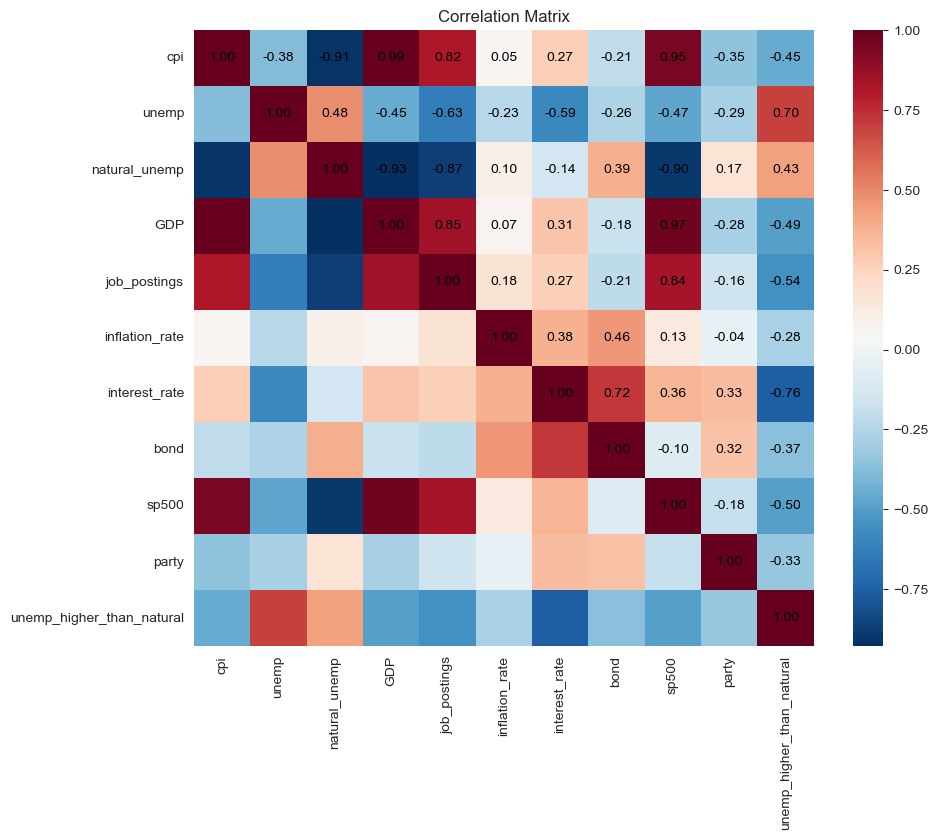

In [476]:
# Explore the correlation between variables
corr_mat = joined_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, cmap='RdBu_r', ax=ax, cbar=True)

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]): # upper triangle only
        val = corr_mat.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
plt.savefig("Visualizations/CorrMat.png", dpi=300, bbox_inches="tight")
plt.show()

Interestingly, GDP and CPI has the correlation of 1.  
We can also see that GDP and S&P500 has high correlation of 0.98, CPI and S&P500 has high correlation of 0.97  
GDP and job postings also has correlation up to 0.84

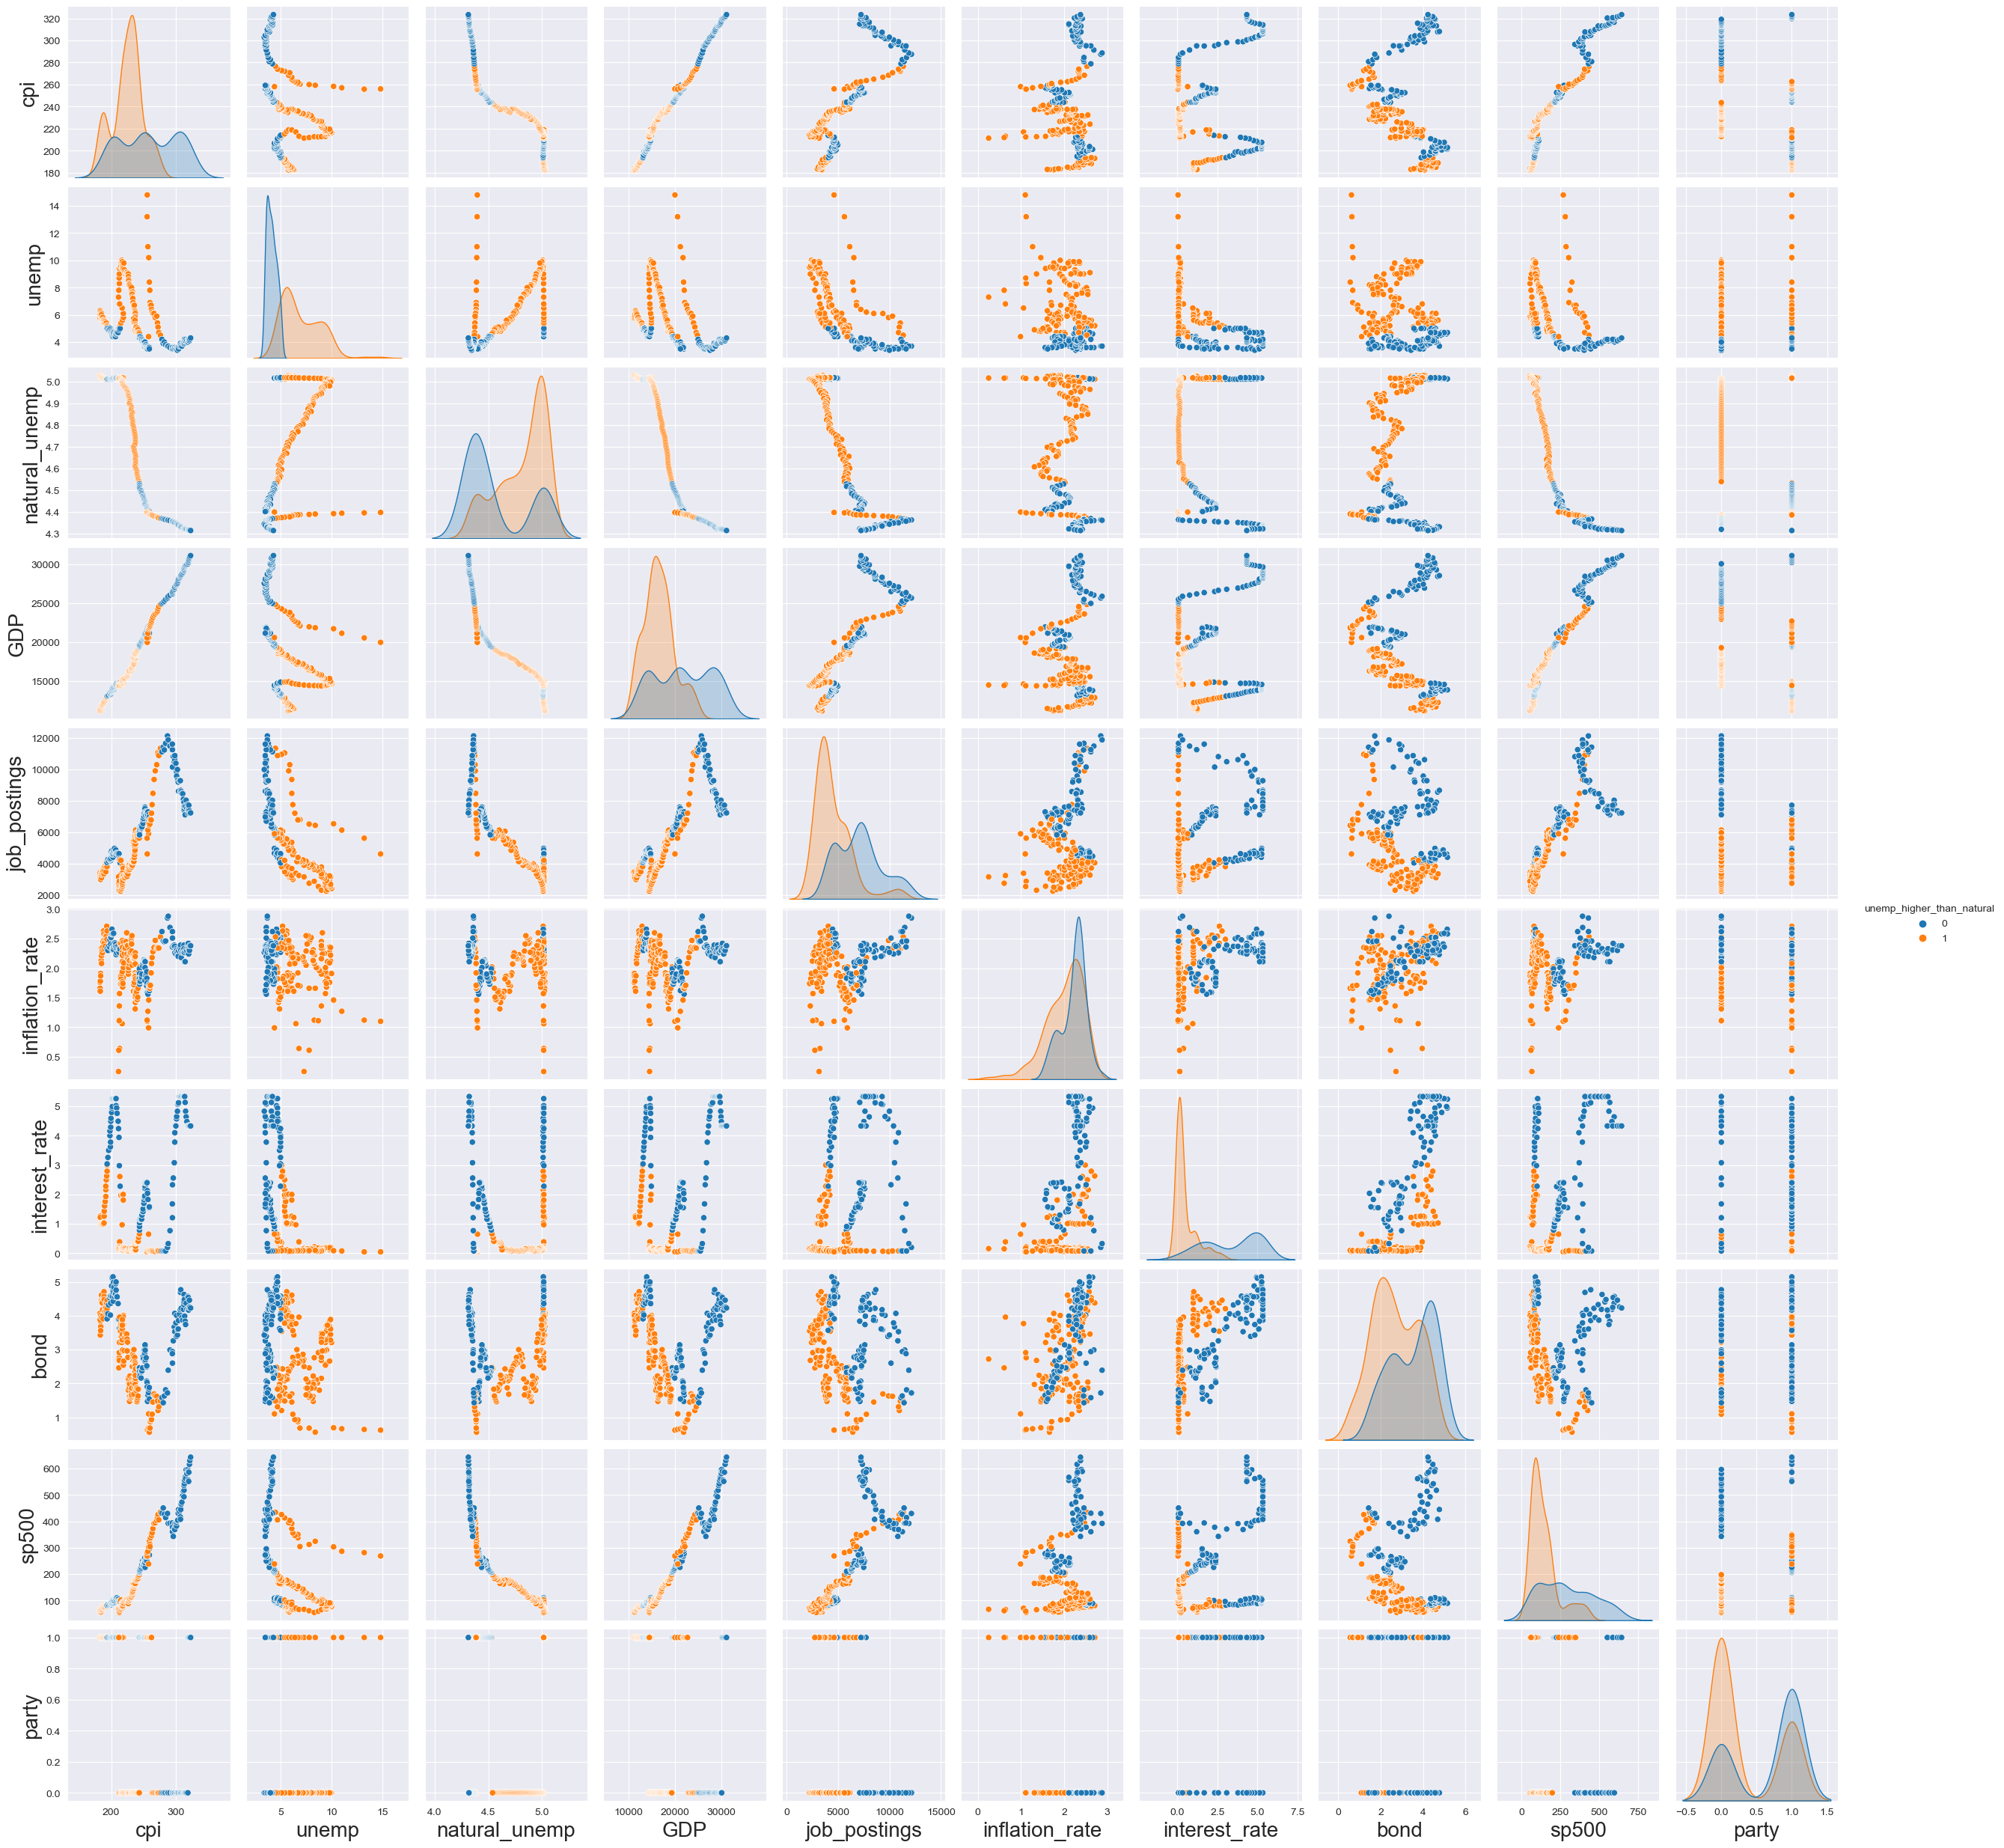

In [477]:
# Pairplots representing the relationships between variables
g = sns.pairplot(joined_df, hue = 'unemp_higher_than_natural')
# Blue for lower, Orange for higher
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig("Visualizations/PairsPlot.png", dpi=300, bbox_inches="tight")
plt.show()

As we can see, the relationship between variables are not linear apart from pairs that have high correlation like CPI and GDP,  
and GDP and SP500

## Fitting Models

Since we can see that not all relationship of variables with Unemployment are linear  
and we want to interpret the relationship between Job Postings and Unemployment here  
So we can try Generalized Additive Models before fitting more complex non-parametric methods

In [478]:
# Splitting the data for training and testing
# We split it at a particular time index for Time Series Data

# Include new variables for time and lag 
df = joined_df.copy()

# time index: 0, 1, 2, ..., T-1
df['time_idx'] = np.arange(len(df))

# 1-step lag of unemployment
df['unemp_lag1'] = df['unemp'].shift(1)

# drop first row where lag is NaN
df = df.dropna()

split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]
dropped = train.drop(['unemp_higher_than_natural', 'unemp'], axis = 1)
print(dropped.columns.tolist())

['cpi', 'natural_unemp', 'GDP', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'time_idx', 'unemp_lag1']


In [479]:
train_X, train_Y = (train.drop(['unemp_higher_than_natural', 'unemp'], axis=1).to_numpy(), 
                    train['unemp'])
test_X, test_Y = (test.drop(['unemp_higher_than_natural', 'unemp'], axis=1).to_numpy(), 
                  test['unemp'])
print(train_X.shape)
print(train_Y.shape)

(216, 11)
(216,)


In [480]:
print(len(train))
print(len(test))

216
55


### Standardizing the data

In [481]:
scaler = StandardScaler()

num_cols = list(range(10))

# scale numeric columns
train_num = scaler.fit_transform(train_X[:, num_cols])
test_num  = scaler.transform(test_X[:, num_cols])

# keep party as is
train_party = train_X[:, 10].reshape(-1, 1)
test_party  = test_X[:, 10].reshape(-1, 1)

# reassemble
train_X_scaled = np.hstack([train_num, train_party])
test_X_scaled  = np.hstack([test_num,  test_party])

### Generalized Additive Models

In [488]:
n_splines_grid = [5, 7, 10, 15]  # fewer → less overfit
lam_grid = np.arange(50, 1000 + 1, 100) # 1 to 1000

print(train_X_scaled.shape)

gam = LinearGAM(
            s(0) + s(1) +             # time index and lagging
            l(2) + l(3) + l(4) +      # cpi, natural_unemp, GDP (example)
            s(5) +       # job_postings
            s(6) +       # inflation_rate
            l(7) + l(8) +             # interest_rate, bond
            s(9) +       # sp500
            f(10)                      # party
        ).gridsearch(train_X_scaled, train_Y, lam=lam_grid)

train_pred = gam.predict(train_X_scaled)
test_pred  = gam.predict(test_X_scaled)

gam.summary()



(216, 11)


ValueError: lam grid must either be iterable of iterables, or an iterable of lengnth > 1, but found 100

In [483]:
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))
print("DOF:", gam.statistics_['edof'])

Train RMSE: 0.551987646166283
Test RMSE: 9.336500661540413
DOF: 17.8694387125579


In [484]:
# Prune our features by removing the smoothest model
gam = LinearGAM(
            l(2) + l(3) +      # cpi, natural_unemp
            s(5) +       # job_postings
            s(6) +       # inflation_rate
            l(7) +       # interest_rate
            s(9) +       # sp500
            f(10)                      # party
        ).gridsearch(train_X_scaled, train_Y, lam=lam_grid)

train_pred = gam.predict(train_X_scaled)
test_pred  = gam.predict(test_X_scaled)

gam.summary()

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.5251
Link Function:                     IdentityLink Log Likelihood:                                  -249.7605
Number of Samples:                          216 AIC:                                              530.5712
                                                AICc:                                             533.1435
                                                GCV:                                                 0.522
                                                Scale:                                              0.4592
                                                Pseudo R-Squared:                                   0.8976
Feature Function                  Lam

/var/folders/nm/dprsbkbn709_l55s2nwhk06m0000gn/T/ipykernel_35231/3473127927.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [485]:
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))
print("DOF:", gam.statistics_['edof'])

Train RMSE: 0.6544605762308642
Test RMSE: 1.0428968934151588
DOF: 14.525122945889354


In [486]:
# Continue Pruning
gam = LinearGAM(
            l(2) + l(3) +      # cpi, natural_unemp
            s(6) +       # inflation_rate
            l(7) +       # interest_rate
            s(9) +       # sp500
            f(10)                      # party
        ).gridsearch(train_X_scaled, train_Y, lam=lam_grid)

train_pred = gam.predict(train_X_scaled)
test_pred  = gam.predict(test_X_scaled)

gam.summary()

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.7927
Link Function:                     IdentityLink Log Likelihood:                                  -254.8114
Number of Samples:                          216 AIC:                                              535.2082
                                                AICc:                                             536.9534
                                                GCV:                                                0.6057
                                                Scale:                                              0.5465
                                                Pseudo R-Squared:                                   0.8765
Feature Function                  Lam

/var/folders/nm/dprsbkbn709_l55s2nwhk06m0000gn/T/ipykernel_35231/2585222942.py:13: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [487]:
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))
print("DOF:", gam.statistics_['edof'])

Train RMSE: 0.7187986887005399
Test RMSE: 2.7625382096558915
DOF: 11.792695414213483


This proves as we remove job postings, we substantially increase the bias of the model